Hello Enrique!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure!

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text here.
</div>

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
#First we import our necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import time


In [2]:
#Import our necessary data 

car_data = pd.read_csv('/datasets/car_data.csv')
display(car_data.head())
car_data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

There is some unfortunate wording with the "NotRepaired" column, we are assuming that a "yes" value here means that the car has NOT undergone any repairs. We are also dealing with a significant amount of missing values in this column, as well as for fuel type and vehicle type.

In [3]:
car_data['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In this context, it seems there is no difference in turning all of the missing values here into "other" since they logically mean the same thing. 

In [4]:
#Fill the missing values with "other"

car_data['VehicleType'] = car_data['VehicleType'].fillna('other')
car_data['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: VehicleType, dtype: int64

In [5]:
car_data['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Let's look at the data and see if the other columns can give us insight into what these values might mean.

In [6]:
car_data[car_data['FuelType'].isna()].sample(30)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
170909,27/03/2016 12:51,350,other,2000,NaN,0,corsa,150000,0,NaN,opel,NaN,27/03/2016 00:00,0,20537,07/04/2016 08:17
77750,30/03/2016 19:43,4899,sedan,2003,manual,211,vectra,150000,0,NaN,opel,no,30/03/2016 00:00,0,58135,07/04/2016 10:47
52647,01/04/2016 12:58,350,small,1999,manual,58,twingo,150000,0,NaN,renault,NaN,01/04/2016 00:00,0,74321,01/04/2016 13:44
333208,30/03/2016 07:57,5999,suv,2003,auto,163,m_klasse,150000,10,NaN,mercedes_benz,NaN,30/03/2016 00:00,0,48346,07/04/2016 00:17
21187,29/03/2016 23:51,690,other,2018,manual,71,astra,150000,6,NaN,opel,no,29/03/2016 00:00,0,75443,01/04/2016 00:46
110795,11/03/2016 14:57,2999,other,2016,manual,125,lupo,150000,6,NaN,volkswagen,NaN,11/03/2016 00:00,0,80339,17/03/2016 22:17
262947,06/03/2016 23:38,7250,bus,2007,manual,105,transporter,150000,4,NaN,volkswagen,NaN,06/03/2016 00:00,0,3116,05/04/2016 17:16
261020,01/04/2016 23:06,2200,other,2002,manual,116,3er,150000,6,NaN,bmw,NaN,01/04/2016 00:00,0,55122,05/04/2016 15:45
335772,01/04/2016 22:54,2200,other,2017,manual,115,zafira,150000,6,NaN,opel,yes,01/04/2016 00:00,0,81247,05/04/2016 23:46
160073,10/03/2016 09:46,2450,other,2017,manual,95,punto,150000,8,NaN,fiat,NaN,10/03/2016 00:00,0,90461,21/03/2016 12:45


There seems to be no clear answer as to why the values are missing, so let's fill the values with the most common value which is "petrol".

In [7]:
car_data['FuelType'] = car_data['FuelType'].fillna('petrol')
car_data['FuelType'].value_counts(dropna=False)

petrol      249247
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [8]:
#Let's check the distribution for the "NotRepaired" column

car_data['NotRepaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

In [9]:
(247161/(247161+36054))

0.8726974206874636

While 87% of the data in this column has the value "no", it would still be a sound approach to turn these missing values into a new value called "unknown". Logically, it is possible to encounter cars in real life without a clear track record of repairs as people may not document all of their repairs. 

In [10]:
car_data['NotRepaired'] = car_data['NotRepaired'].fillna('unknown')
car_data['NotRepaired'].value_counts(dropna=False)

no         247161
unknown     71154
yes         36054
Name: NotRepaired, dtype: int64

In [11]:
#Checking remaining missing values in the dataset

display(car_data.isna().sum()/len(car_data))
display(car_data['Gearbox'].value_counts(dropna=False))
display(car_data['Model'].value_counts(dropna=False))

DateCrawled          0.000000
Price                0.000000
VehicleType          0.000000
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Mileage              0.000000
RegistrationMonth    0.000000
FuelType             0.000000
Brand                0.000000
NotRepaired          0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 251, dtype: int64

Logically for model type, it would be sound to simply turn the missing values into "other", since they are more or less the same value. For gearbox, this seems to be more of an issue of data inputting rather than having an abnormal transmission. We will fill the missing gearbox values with "manual", the dominant value, and replace the missing model types with "other".

In [12]:
car_data['Gearbox'] = car_data['Gearbox'].fillna('manual')
display(car_data['Gearbox'].value_counts(dropna=False))
car_data['Model'] = car_data['Model'].fillna('other')
display(car_data['Model'].value_counts(dropna=False))
display(car_data.isna().sum())
display(car_data.duplicated().sum()) #Checking for duplicate values

manual    288084
auto       66285
Name: Gearbox, dtype: int64

other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

271

We have a miniscule amount of duplicate rows that we can safely drop.

In [13]:
car_data = car_data.drop_duplicates()
car_data.duplicated().sum()

0

In [14]:
#Convert our date columns to datetime type

date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
for col in date_columns:
    car_data[col] = pd.to_datetime(car_data[col])
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354098 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354098 non-null  datetime64[ns]
 1   Price              354098 non-null  int64         
 2   VehicleType        354098 non-null  object        
 3   RegistrationYear   354098 non-null  int64         
 4   Gearbox            354098 non-null  object        
 5   Power              354098 non-null  int64         
 6   Model              354098 non-null  object        
 7   Mileage            354098 non-null  int64         
 8   RegistrationMonth  354098 non-null  int64         
 9   FuelType           354098 non-null  object        
 10  Brand              354098 non-null  object        
 11  NotRepaired        354098 non-null  object        
 12  DateCreated        354098 non-null  datetime64[ns]
 13  NumberOfPictures   354098 non-null  int64   

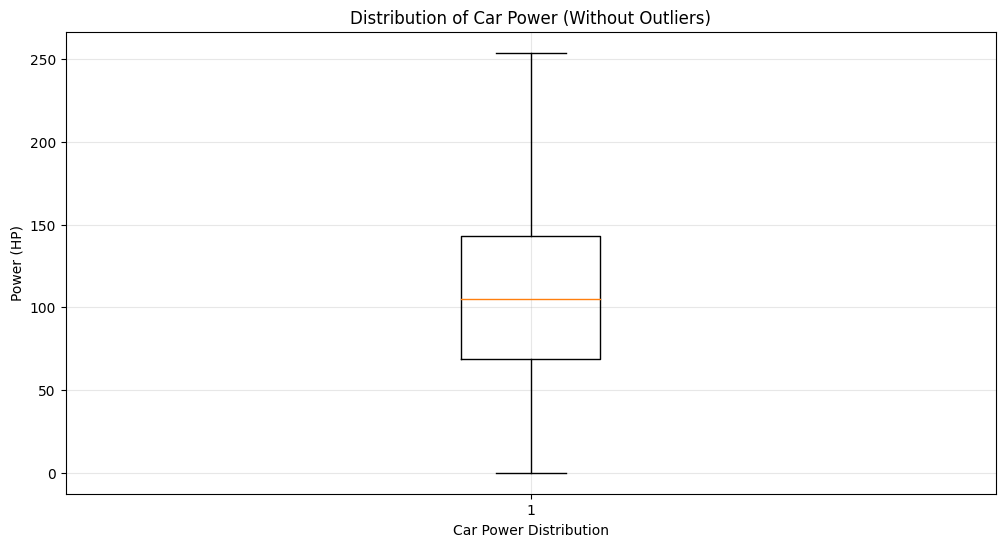

In [15]:
#Checking if car power distribution makes sense

plt.figure(figsize=(12, 6))
plt.boxplot(car_data['Power'], showfliers=False)
plt.title('Distribution of Car Power (Without Outliers)')
plt.xlabel('Car Power Distribution')
plt.ylabel('Power (HP)')
plt.grid(True, alpha=0.3)
plt.show()

It certainly makes no sense for any cars to have 0 horsepower, and setting a reasonable miminum such as 40 makes sense. Additionally, the same is true for the max, it would make no sense to consider cars over a certain power threshold such as 500.

In [16]:
# Calculate percentage of cars under 40 HP
under_40_pct = (car_data['Power'] < 40).mean() * 100

# Calculate percentage of cars over 500 HP
over_500_pct = (car_data['Power'] > 500).mean() * 100

print(f"Percentage of cars under 40 HP: {under_40_pct:.2f}%")
print(f"Percentage of cars over 500 HP: {over_500_pct:.2f}%")

Percentage of cars under 40 HP: 11.76%
Percentage of cars over 500 HP: 0.13%


We can safely drop the rows with cars over 500 horsepower, but why do we have so many values under 40?

In [17]:
car_data = car_data[car_data['Power'] <= 500] #Dropping rows with car horsepower greater than 500
display(car_data['Power'].value_counts())
car_data[car_data['Power'] > 0]['Power'].describe() #Filter over 0 horsepower to avoid throwing off the metrics

0      40218
75     24000
60     15879
150    14571
101    13286
       ...  
489        1
353        1
490        1
475        1
416        1
Name: Power, Length: 413, dtype: int64

count    313421.00000
mean        120.02698
std          53.50339
min           1.00000
25%          75.00000
50%         110.00000
75%         150.00000
max         500.00000
Name: Power, dtype: float64

There's the answer: tons of cars with 0 horsepower which makes no sense. There are too many values here to simply drop. The median and mean are nearly the same, so let's go ahead and fill the 0 values with the median, and then afterwards check how many cars have under 40 horsepower. If it is a miniscule amount, we can safely remove them.

In [18]:
car_data['Power'] = (car_data['Power'].replace(0, car_data[car_data['Power'] > 0]['Power'].median())).astype(int)
display(car_data['Power'].value_counts())
under_40_pct = (car_data['Power'] < 40).mean() * 100
under_40_pct

110    44942
75     24000
60     15879
150    14571
101    13286
       ...  
489        1
490        1
339        1
428        1
356        1
Name: Power, Length: 412, dtype: int64

0.4040843911446419

Cars under 40 horsepower are now under 1% of the data, we can drop these values safely.

In [19]:
car_data = car_data[car_data['Power'] >= 40] #Dropping rows with car horsepower less than 40
display(car_data['Power'].value_counts().sort_index()) 
display(car_data.info())
car_data.head(10)

40     321
41     441
42      50
43     115
44     395
      ... 
485      1
487      2
489      1
490      1
500     39
Name: Power, Length: 373, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352210 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        352210 non-null  datetime64[ns]
 1   Price              352210 non-null  int64         
 2   VehicleType        352210 non-null  object        
 3   RegistrationYear   352210 non-null  int64         
 4   Gearbox            352210 non-null  object        
 5   Power              352210 non-null  int64         
 6   Model              352210 non-null  object        
 7   Mileage            352210 non-null  int64         
 8   RegistrationMonth  352210 non-null  int64         
 9   FuelType           352210 non-null  object        
 10  Brand              352210 non-null  object        
 11  NotRepaired        352210 non-null  object        
 12  DateCreated        352210 non-null  datetime64[ns]
 13  NumberOfPictures   352210 non-null  int64   

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,other,1993,manual,110,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-07-04 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-05-04 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-06-04 10:17:00
5,2016-04-04 17:36:00,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-06-04 19:17:00
6,2016-01-04 20:48:00,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-01-04,0,67112,2016-05-04 18:18:00
7,2016-03-21 18:54:00,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:00
8,2016-04-04 23:42:00,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown,2016-04-04,0,94505,2016-04-04 23:42:00
9,2016-03-17 10:53:00,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,unknown,2016-03-17,0,27472,2016-03-31 17:17:00


We have retained most of our data and made sensible implementations for missing values and nonsensical values.

In [20]:
car_data['NumberOfPictures'].value_counts()

0    352210
Name: NumberOfPictures, dtype: int64

This column gives us no value as all cars have 0 pictures. We can drop this column.

In [21]:
car_data = car_data.drop('NumberOfPictures', axis=1)
car_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,other,1993,manual,110,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,70435,2016-07-04 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-07-04 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-05-04 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-06-04 10:17:00


<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Everything is correct. Good job!
    
</div>

## Model training

In [22]:
#Splitting our features into categorical and numerical
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
numerical_features = ['Power', 'Mileage', 'RegistrationYear', 'RegistrationMonth']

In [23]:
#Dropping columns that won't help with model creation
car_data_filtered = car_data.drop(['DateCrawled','DateCreated','LastSeen','PostalCode'], axis=1)
car_data_filtered.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,other,1993,manual,110,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [24]:
features = car_data_filtered.drop('Price', axis =1)
target = car_data_filtered['Price']

In [25]:
def evaluate_model(model, features_train, features_valid, target_train, target_valid, model_name):
    # Training time
    start_time = time.time()
    model.fit(features_train, target_train)
    training_time = time.time() - start_time
    
    # Prediction time
    start_time = time.time()
    target_pred = model.predict(features_valid)
    prediction_time = time.time() - start_time
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(target_valid, target_pred))
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'Training Time': training_time,
        'Prediction Time': prediction_time
    }


In [26]:
# Convert categorical columns to categorical dtype
for col in categorical_features:
    features[col] = features[col].astype('category')

# Split the data into training set (v3)
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.5, random_state=42)
#Split into validation and test sets (v3)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42)

# Initialize models
models = {
    'LightGBM': lgb.LGBMRegressor(random_state=42, learning_rate=0.15, num_leaves= 24),
    'CatBoost': CatBoostRegressor(
        random_state=42,
        verbose=False,
        cat_features=categorical_features,
        iterations=200,          # Reduce number of iterations
        learning_rate=0.1,      # Slightly higher learning rate
        depth=4)
}

# Evaluate all models
results = []
for name, model in models.items():
    result = evaluate_model(model, features_train, features_valid, target_train, target_valid, name)
    results.append(result)

# Create results DataFrame
results_df_1 = pd.DataFrame(results)

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [27]:
results_df_1

,Model,RMSE,Training Time,Prediction Time
0,LightGBM,1779.621026,2.012499,0.501202
1,CatBoost,1920.130161,17.011688,0.093382


<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct. Well done!
    
</div>

In [28]:
# Convert categorical features using get_dummies with drop_first to train tree-based models and linear regression
features = pd.get_dummies(features, drop_first=True)
# Convert all columns to numeric
features = features.apply(pd.to_numeric)

In [29]:
# Split the data into training set (v3)
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.5, random_state=42)
#Split into validation and test sets (v3)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42)

#Initialize models
models = {'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=30, max_depth=5, random_state=42)}

# Evaluate all models
results = []
for name, model in models.items():
    result = evaluate_model(model, features_train, features_valid, target_train, target_valid, name)
    results.append(result)

# Create results DataFrame
results_df_2 = pd.DataFrame(results)

%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [30]:
results_df_2

,Model,RMSE,Training Time,Prediction Time
0,Linear Regression,2933.405158,6.129817,0.210094
1,Decision Tree,2536.697822,1.254863,0.061417
2,Random Forest,2501.869685,22.660114,0.131683


In [31]:
merged_results = pd.concat([results_df_1, results_df_2], axis=0, ignore_index=True)
merged_results

,Model,RMSE,Training Time,Prediction Time
0,LightGBM,1779.621026,2.012499,0.501202
1,CatBoost,1920.130161,17.011688,0.093382
2,Linear Regression,2933.405158,6.129817,0.210094
3,Decision Tree,2536.697822,1.254863,0.061417
4,Random Forest,2501.869685,22.660114,0.131683


<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Good job!
    
</div>

Our LightGBM model leads the way with the lowest RMSE and second fastest training time. It does have the slowest prediction time but it's still very fast. Decision tree is the fastest model to train but does not have a great RMSE compared to our other models. Linear Regression is the worst here but serves as a good sanity check for our other models.

In [32]:
#Lets tune and test different random forest models

def evaluate_rf_estimators(features_train, features_valid, target_train, target_valid, estimator_range=None):
    if estimator_range is None:
        estimator_range = [10, 50, 100]
    
    results = []
    
    for n_est in estimator_range:
        # Initialize model
        rf = RandomForestRegressor(n_estimators=n_est, max_depth=5, random_state=42) #This depth is a good in-between depth
        
        # Training time
        train_start = time.time()
        rf.fit(features_train, target_train)
        train_time = time.time() - train_start
        
        # Prediction time
        pred_start = time.time()
        target_pred = rf.predict(features_valid)
        pred_time = time.time() - pred_start
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(target_valid, target_pred))
        
        results.append({
            'n_estimators': n_est,
            'RMSE': rmse,
            'Training Time (s)': train_time,
            'Prediction Time (s)': pred_time
        })
    
    # Create DataFrame and sort by RMSE
    results_df_3 = pd.DataFrame(results)
    results_df_3 = results_df_3.sort_values('RMSE')
    
    return results_df_3

# Get results
results = evaluate_rf_estimators(features_train, features_valid, target_train, target_valid)

# Print the results
print("\nResults sorted by RMSE:")
print(results)

# Print the best configuration
best_config = results.iloc[0]
print("\nBest Configuration:")
print(f"n_estimators: {best_config['n_estimators']}")
print(f"RMSE: {best_config['RMSE']:.4f}")
print(f"Training Time: {best_config['Training Time (s)']:.2f} seconds")
print(f"Prediction Time: {best_config['Prediction Time (s)']:.2f} seconds")
%time


Results sorted by RMSE:
   n_estimators         RMSE  Training Time (s)  Prediction Time (s)
1            50  2500.496017          37.356694             0.196092
2           100  2500.696810          75.081549             0.313884
0            10  2507.637283           7.400037             0.082537

Best Configuration:
n_estimators: 50.0
RMSE: 2500.4960
Training Time: 37.36 seconds
Prediction Time: 0.20 seconds
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


So our best random forest model has 50 estimators, but it is only slightly better than with 10 estimators. The difference though is 10 estimators is five times faster to train! So logically, our best model has 10 estimators. Let's test more hyperparamters on LightGBM, which is our current best-performing model all around.

In [33]:
#Re-establish features and target without dummies

features = car_data_filtered.drop('Price', axis =1)
target = car_data_filtered['Price']
# Convert categorical columns to categorical dtype
for col in categorical_features:
    features[col] = features[col].astype('category')
features

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,other,1993,manual,110,golf,150000,0,petrol,volkswagen,unknown
1,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,other,2005,manual,110,colt,150000,7,petrol,mitsubishi,yes
354365,other,2005,manual,110,other,20000,1,petrol,sonstige_autos,unknown
354366,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [34]:
def evaluate_lgb_parameters(features_train, features_valid, target_train, target_valid):
    # Key parameter combinations to test
    param_combinations = [
        {'learning_rate': 0.15, 'n_estimators': 200},
        {'learning_rate': 0.2, 'n_estimators': 200},
        {'learning_rate': 0.25, 'n_estimators': 200}
    ]
    
    results = []
    
    for params in param_combinations:
        # Initialize model with current parameters
        model = lgb.LGBMRegressor(
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            random_state=42,
            num_leaves= 24
        )
        
        # Training time
        train_start = time.time()
        model.fit(features_train, target_train)
        train_time = time.time() - train_start
        
        # Prediction time
        pred_start = time.time()
        target_pred = model.predict(features_valid)
        pred_time = time.time() - pred_start
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(target_valid, target_pred))
        
        results.append({
            'learning_rate': params['learning_rate'],
            'n_estimators': params['n_estimators'],
            'RMSE': rmse,
            'Training Time (s)': train_time,
            'Prediction Time (s)': pred_time
        })
    
    # Create DataFrame and sort by RMSE
    results_df_4 = pd.DataFrame(results)
    results_df_4 = results_df_4.sort_values('RMSE')
    
    return results_df_4

# Split the data into training set (v3)
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.5, random_state=42)
#Split into validation and test sets (v3)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42)

#Get results
results = evaluate_lgb_parameters(features_train, features_valid, target_train, target_valid)

# Print the results
print("\nResults sorted by RMSE:")
print(results)

# Print the best configuration
best_config = results.iloc[0]
print("\nBest Configuration:")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"n_estimators: {best_config['n_estimators']}")
print(f"RMSE: {best_config['RMSE']:.4f}")
print(f"Training Time: {best_config['Training Time (s)']:.2f} seconds")
print(f"Prediction Time: {best_config['Prediction Time (s)']:.2f} seconds")
%time


Results sorted by RMSE:
   learning_rate  n_estimators         RMSE  Training Time (s)  \
1           0.20           200  1738.450288           3.209963   
2           0.25           200  1743.968086           2.716135   
0           0.15           200  1752.325341           2.962409   

   Prediction Time (s)  
1             0.789351  
2             0.779522  
0             0.800752  

Best Configuration:
Learning Rate: 0.2
n_estimators: 200.0
RMSE: 1738.4503
Training Time: 3.21 seconds
Prediction Time: 0.79 seconds
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


Doubling our estimators gives us improved results and only adds seconds to the training and prediction times. This gives us our best model so far(n_estimators=200, learning_rate=0.2). Let's try once more with more estimators and a different range of learning times.

In [35]:
def evaluate_lgb_parameters_2(features_train, features_valid, target_train, target_valid):
    # Key parameter combinations to test
    param_combinations = [
        {'learning_rate': 0.2, 'n_estimators': 300},
        {'learning_rate': 0.3, 'n_estimators': 300}
    ]
    
    results = []
    
    for params in param_combinations:
        # Initialize model with current parameters
        model = lgb.LGBMRegressor(
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            random_state=42
        )
        
        # Training time
        train_start = time.time()
        model.fit(features_train, target_train)
        train_time = time.time() - train_start
        
        # Prediction time
        pred_start = time.time()
        target_pred = model.predict(features_valid)
        pred_time = time.time() - pred_start
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(target_valid, target_pred))
        
        results.append({
            'learning_rate': params['learning_rate'],
            'n_estimators': params['n_estimators'],
            'RMSE': rmse,
            'Training Time (s)': train_time,
            'Prediction Time (s)': pred_time
        })
    
    # Create DataFrame and sort by RMSE
    results_df_5 = pd.DataFrame(results)
    results_df_5 = results_df_5.sort_values('RMSE')
    
    return results_df_5

#Get results
results = evaluate_lgb_parameters_2(features_train, features_valid, target_train, target_valid)

# Print the results
print("\nResults sorted by RMSE:")
print(results)

# Print the best configuration
best_config = results.iloc[0]
print("\nBest Configuration:")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"n_estimators: {best_config['n_estimators']}")
print(f"RMSE: {best_config['RMSE']:.4f}")
print(f"Training Time: {best_config['Training Time (s)']:.2f} seconds")
print(f"Prediction Time: {best_config['Prediction Time (s)']:.2f} seconds")
%time


Results sorted by RMSE:
   learning_rate  n_estimators         RMSE  Training Time (s)  \
0            0.2           300  1721.936660           4.085413   
1            0.3           300  1730.231658           3.789910   

   Prediction Time (s)  
0             1.224908  
1             1.208450  

Best Configuration:
Learning Rate: 0.2
n_estimators: 300.0
RMSE: 1721.9367
Training Time: 4.09 seconds
Prediction Time: 1.22 seconds
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


We see even further improvement without a noticeable hindrance in processing time. This gives us our best model. Can CatBoost do any better?  

In [36]:
def evaluate_catboost_parameters(features_train, features_valid, target_train, target_valid):
    # Key parameter combinations to test
    param_combinations = [
        {'learning_rate': 0.1, 'iterations': 400},
        {'learning_rate': 0.15, 'iterations': 400},
        {'learning_rate': 0.2, 'iterations': 400}
    ]
    
    results = []
    
    for params in param_combinations:
        # Initialize model with current parameters
        model = CatBoostRegressor(
            learning_rate=params['learning_rate'],
            iterations=params['iterations'],
            random_seed=42,
            verbose=False,
            cat_features = categorical_features
        )
        
        # Training time
        train_start = time.time()
        model.fit(features_train, target_train)
        train_time = time.time() - train_start
        
        # Prediction time
        pred_start = time.time()
        target_pred = model.predict(features_valid)
        pred_time = time.time() - pred_start
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(target_valid, target_pred))
        
        results.append({
            'learning_rate': params['learning_rate'],
            'iterations': params['iterations'],
            'RMSE': rmse,
            'Training Time (s)': train_time,
            'Prediction Time (s)': pred_time
        })
    
    # Create DataFrame and sort by RMSE
    results_df_5 = pd.DataFrame(results)
    results_df_5 = results_df_5.sort_values('RMSE')
    
    return results_df_5

# Get results
results = evaluate_catboost_parameters(features_train, features_valid, target_train, target_valid)

# Print the results
print("\nResults sorted by RMSE:")
print(results)

# Print the best configuration
best_config = results.iloc[0]
print("\nBest Configuration:")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Iterations: {best_config['iterations']}")
print(f"RMSE: {best_config['RMSE']:.4f}")
print(f"Training Time: {best_config['Training Time (s)']:.2f} seconds")
print(f"Prediction Time: {best_config['Prediction Time (s)']:.2f} seconds")
%time


Results sorted by RMSE:
   learning_rate  iterations         RMSE  Training Time (s)  \
2           0.20         400  1776.113512          52.487344   
1           0.15         400  1784.197189          52.760068   
0           0.10         400  1804.463528          51.929935   

   Prediction Time (s)  
2             0.241615  
1             0.225820  
0             0.203082  

Best Configuration:
Learning Rate: 0.2
Iterations: 400.0
RMSE: 1776.1135
Training Time: 52.49 seconds
Prediction Time: 0.24 seconds
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


The results have improved significantly, but training time is drastically longer than LightGBM models. The RMSE is also __still__ lower for LightGBM models as well, so our CatBoost models are redundant, even with improved results.

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Am I right that you used test data to tune the hyperparameters in all the models above? You can't do it. Please, use a validation data for this purpose. You can calculate training and prediction time only for the best model of each type. In such case it's okay to use a test data.
    
</div>

<div class="alert alert-block alert-info">
<b>Student answer. (v2)</b> <a class="tocSkip"></a>

Total oversight. Apologies!    
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

It seems now you use train data instead of the test one. It's even worse. To tune the hyperparameters you can use only validation data
    
</div>

<div class="alert alert-block alert-info">
<b>Student answer. (v3)</b> <a class="tocSkip"></a>

__Fixed. Analysis has changed slightly.__    
</div>

Let's verify our best random forest and LightGBM models on the test data, display their RMSE, and display their processing time.

In [37]:
#Best random forest and LightGBM models based on previous testing

best_rf = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
best_lgb = lgb.LGBMRegressor(
            learning_rate=0.2,
            n_estimators=300,
            random_state=42)

# Train and evaluate LightGBM
lgb_start_time = time.time()
best_lgb.fit(features_train, target_train)
lgb_train_time = time.time() - lgb_start_time

lgb_pred_start = time.time()
lgb_predictions = best_lgb.predict(features_test)
lgb_pred_time = time.time() - lgb_pred_start

lgb_rmse = np.sqrt(mean_squared_error(target_test, lgb_predictions))

# Display results

print("\nLightGBM Results:")
print(f"RMSE: {lgb_rmse:.4f}")
print(f"Training Time: {lgb_train_time:.2f} seconds")
print(f"Prediction Time: {lgb_pred_time:.2f} seconds")
%time


LightGBM Results:
RMSE: 1720.3092
Training Time: 3.99 seconds
Prediction Time: 1.32 seconds
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


We need to use get_dummies in order to verify the random forest model.

In [38]:
features = pd.get_dummies(features, drop_first=True)

# Split the data into training set (v3)
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.5, random_state=42)
#Split into validation and test sets (v3)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=42)

# Train and evaluate Random Forest
rf_start_time = time.time()
best_rf.fit(features_train, target_train)
rf_train_time = time.time() - rf_start_time

rf_pred_start = time.time()
rf_predictions = best_rf.predict(features_test)
rf_pred_time = time.time() - rf_pred_start

rf_rmse = np.sqrt(mean_squared_error(target_test, rf_predictions))

# Display results
print("Random Forest Results:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"Training Time: {rf_train_time:.2f} seconds")
print(f"Prediction Time: {rf_pred_time:.2f} seconds")

Random Forest Results:
RMSE: 2509.6447
Training Time: 7.39 seconds
Prediction Time: 0.08 seconds


__Both models exhibit similar results using both the training data and the test data.__

## Model analysis

Now that our models are complete, we can analyze our findings and see if we have achieved our objective.

__What did we train?__

We trained various models such as linear regression, random forest, decision tree, and gradient boosting models such as LightGBM and CatBoost.

__What did we find?__

Linear regression had the worst result but serves as our sanity check. All other models should perform better than linear regression as a base line, and they all did. Decision tree was very fast but did not have great results. Random forest had better results but a very slow training time. Our LightGBM and CatBoost models were way better, with our best LightGBM model attaining an RMSE of 1720 and still remaining incredibly quick in training and prediction time. CatBoost took much longer to train and still had worser results than LightGBM (but still better overall than tree-based models), making it redundant for our model selection. We confirmed the validity of our LightGBM model with the test data.

__Did we achieve our objective?__

We can say definitively that we achieved our objective with our best LightGBM model (learning rate 0.2, number of estimators 300) which was not only the most accurate, but still lightning fast with total processing time under 7 seconds, which would be a reasonable amount of time to wait on an application. 

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed